In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR
import scipy
from scipy import signal
from torchvision import transforms

In [3]:
orgin_raw_data_dir = 'C:\\Users\\a1882\\Desktop\\EEG\\new_implement\\data\\orgin_raw_data_slid_window_slice_3000'
model_save ='C:\\Users\\a1882\\Desktop\\EEG\\new_implement\\model'
pic_dir = 'C:\\Users\\a1882\\Desktop\\EEG\\new_implement\\pic'

In [44]:
def stackfy(fram):
    stack = torch.zeros(4,32,389,515)
    for i in range(32):
        stack[:,i,:,:] = spect(fram.iloc[i,:].to_numpy())
    return stack

def spect(signa):
    freq = 128
    #t = np.arrange(0, 3000/freq, 1/freq)
    freqs, times, Sx = signal.spectrogram(signa, freq)
    amplitude = np.abs(Sx)
    sp = plt.pcolormesh(times, freqs, np.log(amplitude), shading='gouraud')
    plt.axis('off')
    plt.savefig('image.png', bbox_inches='tight')

    # 加载图像，并将其转换为张量
    image = plt.imread('image.png')
    tensor_data = transforms.ToTensor()(image)
    #tensor_data = tensor.permute(3,0,1,2)
    return tensor_data

In [38]:
class EEG_Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = orgin_raw_data_dir
        self.file_list = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        data = pd.read_csv(file_path, header=None)
        image_tensor = stackfy(data)
        # tensor_data = transforms.ToTensor()(image)
        #data = torch.from_numpy(data)
        label_map = {'lefthand': 0, 'read': 1, 'rest': 2, 'walkbase': 3, 'walkl': 4 ,'walkfocus': 5}
        data_label = label_map[file_name.split('_')[0]]
        return image_tensor, data_label

In [39]:
dataset = EEG_Dataset(orgin_raw_data_dir)

train_size = int(0.6 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset,valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,valid_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [45]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv3d(4,32,kernel_size = 3, stride = 1, padding = 1)
        self.bn1 = nn.BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool3d(kernel_size = 2, stride = 2, padding = 0)
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv3d(32,32,kernel_size = 3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool3d(kernel_size = 2, stride = 2, padding = 0)
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(3178496, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 6)


    def forward(self, x):
        #x = torch.squeeze(x,dim=0)
        # print('x:', x.shape)
        x = self.conv1(x)
        # print('conv1:', x.shape)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        # print('conv2:', x.shape)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        # print('flatten:', x.shape)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [46]:
X = torch.randn(size=(1,4,32,389,515), dtype=torch.float32)
model = EEGNet()
output = model(X)
print(output.shape)
print(output)

torch.Size([1, 6])
tensor([[-0.6131,  0.8697,  0.0147, -0.1570, -0.0733, -0.0345]],
       grad_fn=<AddmmBackward0>)


In [47]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.cuda.is_available()
    else "cpu"
)
# device = ("cpu")
print(f"Using {device} device")

Using cpu device


In [48]:
learning_rate = 0.0001
num_epochs = 30
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [49]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            global train_loss
            train_loss.append(loss)


def valid(dataloader, model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            valid_loss += loss_fn(pred, y).item()
            valid_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    valid_loss /= num_batches
    valid_correct /= size
    print(f"Valid Error:\n Accuracy: {(100 * valid_correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    global validloss
    validloss.append(valid_loss)
    global validaccuracy
    validaccuracy.append(valid_correct)


def test(dataloader, model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    global testloss
    testloss.append(test_loss)
    global testaccuracy
    testaccuracy.append(correct)

Epoch 1
-------------------------------


C:\Users\a1882\AppData\Local\Temp\ipykernel_1440\3797706363.py:12: RuntimeWarning: divide by zero encountered in log
  sp = plt.pcolormesh(times, freqs, np.log(amplitude), shading='gouraud')
C:\Users\a1882\AppData\Local\Temp\ipykernel_1440\3797706363.py:12: RuntimeWarning: divide by zero encountered in log
  sp = plt.pcolormesh(times, freqs, np.log(amplitude), shading='gouraud')


loss: 2.144233  [    0/ 2360]


C:\Users\a1882\AppData\Local\Temp\ipykernel_1440\3797706363.py:12: RuntimeWarning: divide by zero encountered in log
  sp = plt.pcolormesh(times, freqs, np.log(amplitude), shading='gouraud')


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 3282288640 bytes.

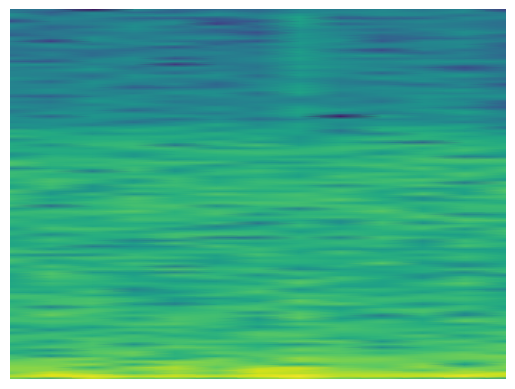

In [50]:
# model = model.cuda()
train_loss = []
validloss = []
testloss = []
validaccuracy = []
testaccuracy = []
for t in range(num_epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    model.train(True)
    train(train_loader, model, loss_fn, optimizer)

    model.train(False)
    test(valid_loader, model, loss_fn)

    model.train(False)
    test(test_loader, model, loss_fn)

    if t > num_epochs-5:
        torch.save(model.state_dict(), 'cnn_3000_30e_'+str(t)+'.pt')


print("Done!")